# Lab 5: Bayesian Logistic Regression

### Lab Date: Wednesday, February 26

### Due: Wednesday, March 5

## Instructions

Work with your lab group to complete the following notebook. Your work will be reviewed by your peers in lab next week (Wednesday, March 5th).

In this lab, you will work through a Bayesian logistic regression problem using real data. You will learn how to:
1. Selecting well-grounded priors.
2. Implementing Bayesian inference using Metropolis-Hastings MCMC sampling.
3. Returning interval estimates for each unknown propensity (player skill levels).
4. Modeling match outcomes (win, loss, and draw) explicitly.
5. Visualizing the posterior mean of inferred player skills.

If you are new to working in python, or in a Jupyter notebook, please ask your lab members for help. If you notice a lab member struggling, and have experience, please offer your help.

Please see this [Ed post](https://edstem.org/us/courses/74615/discussion/6192475) for corrections, questions, and discussion. If you would rather work with your own copy of the files, I have uploaded a zip folder there with the lab materials. 

Corrections to the lab will be pushed directly to this notebook. We will only push corrections to the text, which is set to read only to prevent merge conflicts. In the event of a merge conflict, save your notebook under a different name, and click the link that launches the lab from the schedule on the [stat238 homepage](https://stat238.berkeley.edu/spring-2025/) again. Then, check for discrepancies. If you can't find them, or resolve the conflict, contact us.

In [1]:
# load whatever packages you prefer here. We've added a reference list here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, beta

## Step 1: Load and Explore Data

1. Load the dataset containing chess game results with player IDs but no Elo ratings.
2. Rename columns for clarity.
3. Identify unique players and assign a numeric index to each.

In [2]:
# Load training dataset
train_path = "training_data.csv"
data = pd.read_csv(train_path)

# Rename columns for clarity
data.columns = ['Month', 'White_Player', 'Black_Player', 'Score']

# Convert score values (0 = loss, 0.5 = draw, 1 = win) to indices (0 = loss, 1 = draw, 2 = win)
data['Score_Index'] = data['Score'].map({0: 0, 0.5: 1, 1: 2})

# Identify unique players in both White and Black roles
players = set(data['White_Player']).union(set(data['Black_Player']))
n_players = len(players)  # Total number of unique players

# Create a dictionary to map player IDs to a numeric index
player_map = {player: i for i, player in enumerate(players)}

# Map player IDs to indices in the dataset
data['White_Index'] = data['White_Player'].map(player_map)
data['Black_Index'] = data['Black_Player'].map(player_map)

## Step 2: Define Bayesian Logistic Regression Model

1. Assign each player a latent skill (Elo-like rating) drawn from a **well-grounded prior**.
2. Priors should be:
    - Weakly informative (e.g., Normal(0,1)) to allow data to dominate.
    - Derived using the invariance principle to ensure meaningful skill comparisons.
    - Empirically justified by looking at past Elo rating distributions.
3. Use a multinomial logistic model to predict three possible outcomes: win, loss, and draw.

### Initialize player skills with a normal prior

In [3]:
# For student
np.random.seed(42)
skills = np.random.normal(0, 1, n_players)  # Mean 0, standard deviation 1

### Define likelihood function for multinomial outcomes

In [4]:
# For student
def softmax_probabilities(skill_diff):
    """Compute probabilities for win, draw, and loss using a softmax function."""
    win_exp = np.exp(skill_diff)
    draw_exp = np.exp(-abs(skill_diff))  # Draw probability decreases with skill difference
    loss_exp = np.exp(-skill_diff)
    probs = np.array([loss_exp, draw_exp, win_exp])
    return probs / probs.sum()

def log_likelihood(skills, data):
    log_prob = 0
    for _, row in data.iterrows():
        w, b, outcome = int(row['White_Index']), int(row['Black_Index']), row['Score']
        skill_diff = skills[w] - skills[b]
        probs = softmax_probabilities(skill_diff)
        
        log_prob += np.log(max(probs[int(outcome)], 1e-9))  # Avoid log(0) errors
    return log_prob

## Step 3: Implement Metropolis-Hastings for Posterior Inference

1. Sample new skill levels using a Gaussian proposal distribution.
2. Accept or reject new samples based on the likelihood ratio.
3. Run multiple iterations to approximate the posterior distribution.

In [5]:
# For students
def metropolis_hastings(skills, data, iterations=500, step_size=0.1):
    samples = [skills.copy()]
    current_ll = log_likelihood(skills, data)
    for _ in range(iterations):
        new_skills = skills + np.random.normal(0, step_size, size=n_players)
        new_ll = log_likelihood(new_skills, data)
        acceptance_ratio = np.exp(min(new_ll - current_ll, 100))  # Prevent overflow
        if np.random.rand() < acceptance_ratio:
            skills = new_skills
            current_ll = new_ll
        samples.append(skills.copy())
    return np.array(samples)

In [6]:
# Run MCMC sampling
samples = metropolis_hastings(skills, data)

## Step 4: Compute Posterior Estimates and Interval Estimates

1. Compute **posterior means** for player skills.
2. Compute **95% credible intervals** to quantify uncertainty.

In [7]:
skill_means = samples.mean(axis=0)
skill_intervals = np.percentile(samples, [2.5, 97.5], axis=0)

## Step 5: Visualize Posterior Mean

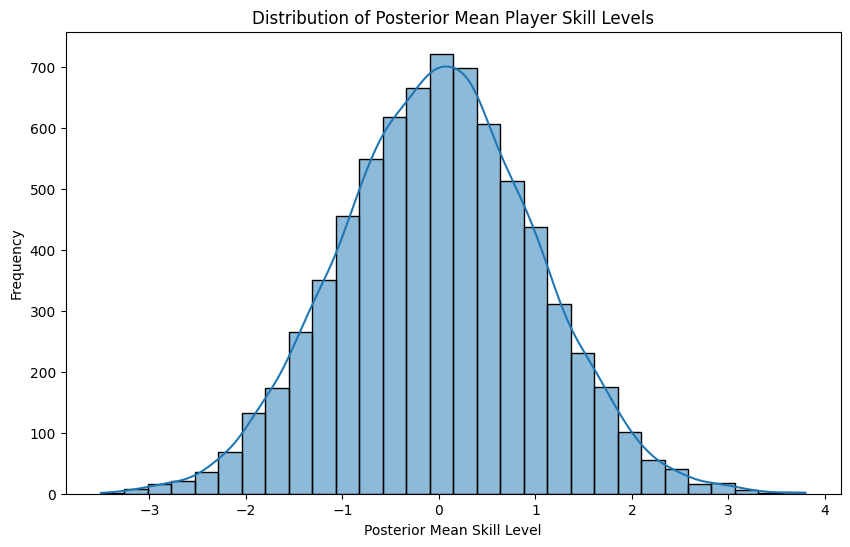

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(skill_means, bins=30, kde=True)
plt.xlabel("Posterior Mean Skill Level")
plt.ylabel("Frequency")
plt.title("Distribution of Posterior Mean Player Skill Levels")
plt.show()